In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
# import the data
raw_df = pd.read_excel('table_8.xls')
raw_df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson
0,Adelanto,31165,198,2,NaN,15,52,129,886,381,372,133,17
1,Agoura Hills,20762,19,0,NaN,2,10,7,306,109,185,12,7
2,Alameda,76206,158,0,NaN,10,85,63,1902,287,1285,330,17
3,Albany,19104,29,0,NaN,1,24,4,557,94,388,75,7
4,Alhambra,84710,163,1,NaN,9,81,72,1774,344,1196,234,7


In [3]:
# create new df with the desired coulmns and change their name
df = raw_df[['Property\ncrime', 'Population', 'Murder and\nnonnegligent\nmanslaughter', 'Robbery']]
df.columns = ['Property_crime','Population', 'Murder', 'Robbery']

# show the new df smaller
df.head()

,Property_crime,Population,Murder,Robbery
0,886,31165,2,52
1,306,20762,0,10
2,1902,76206,0,85
3,557,19104,0,24
4,1774,84710,1,81


### Look into the data

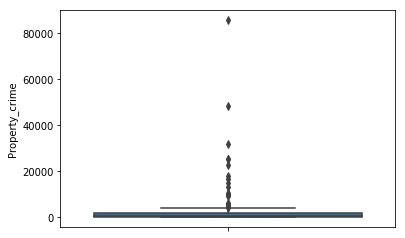

In [4]:
sns.boxplot(df["Property_crime"], orient='v')

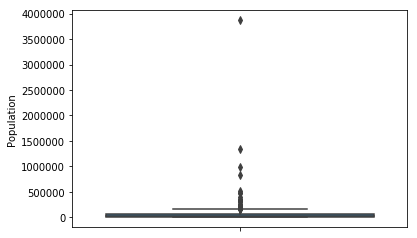

In [5]:
sns.boxplot(df["Population"], orient='v')

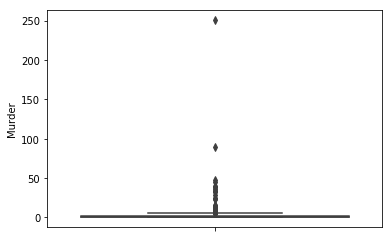

In [6]:
sns.boxplot(df["Murder"], orient='v')

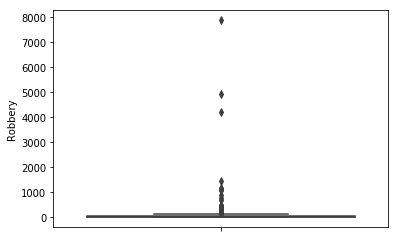

In [7]:
sns.boxplot(df["Robbery"], orient='v')

In [8]:
# Z-socre (look for outliers)
z = np.abs(stats.zscore(df))
#print(z)

# larger than |3| std away
threshold = 3

Clearly, there are outliers that need to be removed. So, let's do it next

In [9]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print((IQR))

print("\ntotal number of outliers:")
print(((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum())

Property_crime     1598.25
Population        59720.00
Murder                2.00
Robbery              60.75
dtype: float64

total number of outliers:
Property_crime    30
Population        29
Murder            46
Robbery           45
dtype: int64


### Remove outliers

In [10]:
print("Before removal, the length of the df is: {}\n".format(len(df)))

# removing using IQR * 1.5
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

print("After removal, the length of the df is: {}\n".format(len(df)))

# reset indexes
df.reset_index(drop=True, inplace=True)

# show table
df.head()

Before removal, the length of the df is: 462

After removal, the length of the df is: 396



,Property_crime,Population,Murder,Robbery
0,886,31165,2,52
1,306,20762,0,10
2,1902,76206,0,85
3,557,19104,0,24
4,1774,84710,1,81


In [11]:
# # create and insert population^2 
pp_sqrd = df['Population'] ** 2

# print(type(pp_sqrd))

df.insert(2, 'Population_sqrd', pp_sqrd, True)

df.head()

,Property_crime,Population,Population_sqrd,Murder,Robbery
0,886,31165,971257225,2,52
1,306,20762,431060644,0,10
2,1902,76206,5807354436,0,85
3,557,19104,364962816,0,24
4,1774,84710,7175784100,1,81


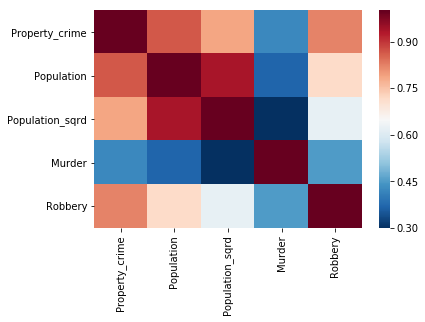

In [12]:
# check their correlation
correlation = df.corr()
# print(correlation)

# see in heatmap 
sns.heatmap(correlation, cmap="RdBu_r")

In [13]:
X = df[['Population', 'Population_sqrd', 'Murder', 'Robbery']]
y = df['Property_crime']

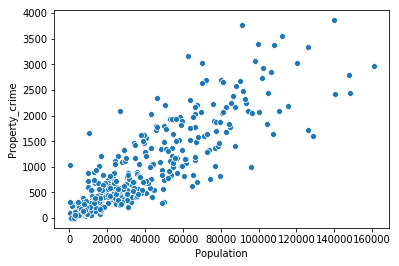

In [14]:
sns.scatterplot(x=X['Population'], y=y)

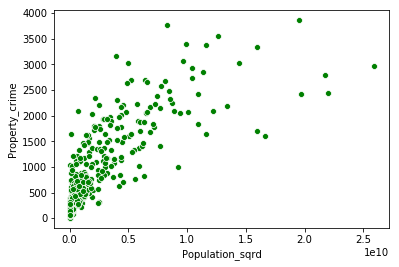

In [15]:
sns.scatterplot(x=X['Population_sqrd'], y=y, color='green')

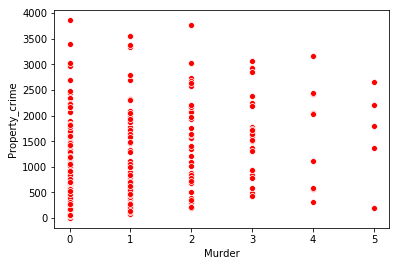

In [16]:
sns.scatterplot(x=X['Murder'], y=y, color='red')

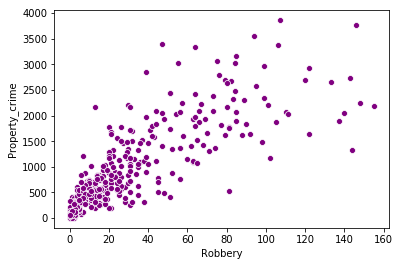

In [17]:
sns.scatterplot(x=X['Robbery'], y=y, color='purple')

From above figures, it seems like there is a connection; only murder looks categorical. Next, find R^2 and continue

In [18]:
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# finding R^2
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test, y_test))


Coefficients: 
 [1.51411606e-02 1.70824658e-09 2.05379858e+01 9.38613128e+00]

Intercept: 
 42.653954285353166

R-squared:
0.8206902356526743


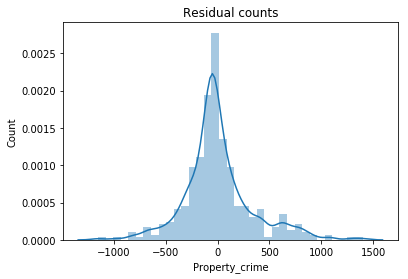

In [19]:
# find and plot residual

# Extract predicted values.
predicted = regr.predict(X).ravel()
# actual values.
actual = df["Property_crime"]

# Calculate the error, also called the residual.
residual = actual - predicted

# histogram plot
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
sns.distplot(residual)
plt.show()

Text(0.5, 1.0, 'Residual graph')

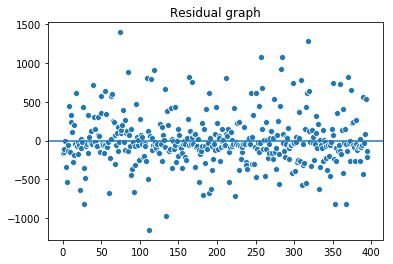

In [20]:
# scatter plot with a lint at y=0
sns.scatterplot(data=residual)
plt.axhline(0)
plt.title("Residual graph")

### Next, I will make murder and robbery binary categorical and find out if R^2 gets better 

In [21]:
df.head()

,Property_crime,Population,Population_sqrd,Murder,Robbery
0,886,31165,971257225,2,52
1,306,20762,431060644,0,10
2,1902,76206,5807354436,0,85
3,557,19104,364962816,0,24
4,1774,84710,7175784100,1,81


In [22]:
for col in ['Murder', 'Robbery']: 
    df[col] = (df[col] > 0).astype(int)
    
df.head()

,Property_crime,Population,Population_sqrd,Murder,Robbery
0,886,31165,971257225,1,1
1,306,20762,431060644,0,1
2,1902,76206,5807354436,0,1
3,557,19104,364962816,0,1
4,1774,84710,7175784100,1,1


In [23]:
X = df[['Population', 'Population_sqrd', 'Murder', 'Robbery']]

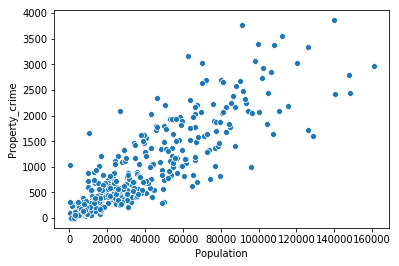

In [24]:
# take a look again at the scatterplot plots

sns.scatterplot(x=X['Population'], y=y)

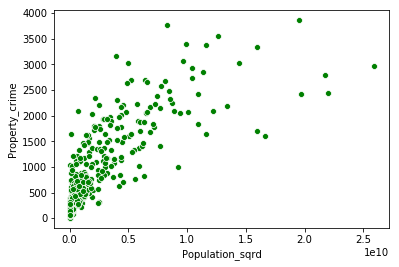

In [25]:
sns.scatterplot(x=X['Population_sqrd'], y=y, color='green')

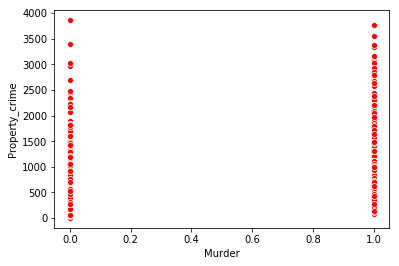

In [26]:
sns.scatterplot(x=X['Murder'], y=y, color='red')

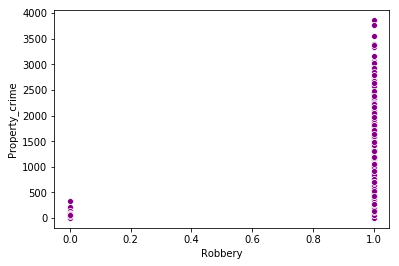

In [27]:
sns.scatterplot(x=X['Robbery'], y=y, color='purple')

In [28]:
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# finding R^2
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test, y_test))


Coefficients: 
 [ 2.27711920e-02 -1.19032939e-08  1.83847297e+02  5.59565195e+01]

Intercept: 
 -42.33149695886311

R-squared:
0.7179269434804909


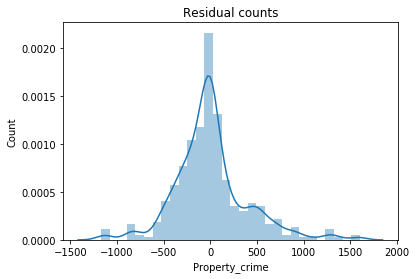

In [29]:
# find and plot residual

# Extract predicted values.
predicted = regr.predict(X).ravel()
# actual values.
actual = df["Property_crime"]

# Calculate the error, also called the residual.
residual = actual - predicted

# histogram plot
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
sns.distplot(residual)
plt.show()

R^2 is a lower, and the residual graph also looks less "normally distributed"; therefore, it can be assumed that making 'Murder' and 'Robbery' binary made the prediction less useful.